# Crypto Currency Prediction model based on time-series data

## Data Collection

### Collect OHLCV Data (open, highest, lowest, closed, volume)

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
from datetime import datetime
from datetime import timedelta
import pandas as pd

In [2]:
# Retrieve all price changes from Polygon API
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
polygonApiKey = user_secrets.get_secret("PolygonAPIKey")


In [3]:
# Get Ticker Overview
POLYGON_URL="https://api.polygon.io"
COIN_NAME="ETH"
CURRENCY="USD"
response = requests.get(
    url=f"{POLYGON_URL}/v3/reference/tickers" ,
    params={
        "market": "crypto",
        "active": "true",
        "apiKey": polygonApiKey,
        "ticker": f"X:{COIN_NAME}{CURRENCY}",
        "order": "desc"
    }
)

print(json.dumps(response.json(), indent=4))


{
    "results": [
        {
            "ticker": "X:ETHUSD",
            "name": "Ethereum - United States dollar",
            "market": "crypto",
            "locale": "global",
            "active": true,
            "currency_symbol": "USD",
            "currency_name": "United States dollar",
            "base_currency_symbol": "ETH",
            "base_currency_name": "Ethereum",
            "last_updated_utc": "2017-01-01T00:00:00Z"
        }
    ],
    "status": "OK",
    "request_id": "b86d4c27ad59ca3537768fd03074801e",
    "count": 1
}


In [11]:
# Set Date and Time formats
DATE_FORMAT = "%Y-%m-%d"
TIME_FORMAT = '%H:%M'

Current Polygon plan is a free so single request for 2 year-old data is not possible. Gradually adjust the dates and run the script.

In [5]:
# Custom Bars Polygon API
MULTIPLIER = 1
TIMESPAN = "hour"
#TO = datetime.today().strftime(DATE_FORMAT)
TO = datetime(2023,11, 8).strftime(DATE_FORMAT)
FROM = (datetime(2022,11, 8) - timedelta(days=365)).strftime(DATE_FORMAT)
#FROM = (datetime(2023,9,16)).strftime(DATE_FORMAT)

url = f"{POLYGON_URL}/v2/aggs/ticker/X:{COIN_NAME}{CURRENCY}/range/{MULTIPLIER}/{TIMESPAN}/{FROM}/{TO}"
all_responses = []

while True:
    next_url = None
    response = requests.get(
        url=url,
        params={
            "apiKey": polygonApiKey,
            "sort": "acs", # oldest at the top
            "limit": 50000
        }
    )
    if response.json().get("results", None):
        all_responses.append(response)
    next_url = response.json().get("next_url", None)
    print(next_url)
    if not next_url:
        break
    url = next_url

print(len(all_responses))

None
0


After each response, save it in csv file. Save it, extract the data to final list. Once ready, upload as a dataset to Kaggle.

In [6]:
output_file_name = f"{COIN_NAME.lower()}-historical-trading.csv"
first_chunk = True
# read response data
for response in all_responses:
    #print(json.dumps(response.json(), indent=4))
    data=response.json().get("results", None)
    if not data:
        break
    
    hitorical_prices_df = pd.DataFrame(data)
    
    # adjust data
    hitorical_prices_df["t"] = pd.to_datetime(hitorical_prices_df["t"], unit="ms")
    
    # this project follows time series forecasting model. To predict a target price,need to use previous point information. 
    hitorical_prices_df["target_next_close"] = hitorical_prices_df["c"].shift(-1) 
    hitorical_prices_df.sort_values(
        by="t",
        ascending=False,
        inplace=True
    )
    
    hitorical_prices_df = hitorical_prices_df.rename(columns={
        "v": "volume",
        "vw": "volume-weighted",
        "o": "open",
        "c": "closed",
        "h": "highest",
        "l": "lowest",
        "t": "timestamp",
        "n": "n_transactions"
    })
    
    #convert to csv file
    hitorical_prices_df.to_csv( 
        output_file_name,
        mode="a",
        date_format=f"{DATE_FORMAT} {TIME_FORMAT}",
        header=first_chunk,
        index=False,
        columns=["timestamp", "open", "lowest", "highest", "closed", "volume", "volume-weighted", "n_transactions", "target_next_close"]
    )
    first_chunk=False

### Data collection result. 

Two above code sections were adjusted and run several times to bypass the actual limitation of free tier subscription for Polygon API. Final result is actually loaded in inputs of this notebook. It is a csv file.

## Feature Engineering and Analysis

In [4]:
df = pd.read_csv("/kaggle/input/initial-ohlcv-eth-prices/eth-historical-trading.csv")
df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,timestamp,open,lowest,highest,closed,volume,volume-weighted,n_transactions,target_next_close
0,2025-11-06 23:00,3317.60,3288.16,3321.5,3313.46,5.439.149.496.040.020,33.019.511,37020,NaN
1,2025-11-06 22:00,3325.74,3294.00,3330.5,3317.60,39.778.437.737.200.200,33.125.936,36172,3313.46
2,2025-11-06 21:00,3304.80,3290.80,3335.4,3324.55,7.324.918.766.570.000,3.308.699,21589,3317.60
3,2025-11-06 20:00,3324.23,3285.43,3337.0,3304.52,1.324.003.594.831.000,33.064.478,34117,3324.55
4,2025-11-06 19:00,3327.29,3306.08,3363.0,3324.23,7.664.137.829.250.000,33.294.853,27578,3304.52


### Data type conversion

In [5]:
# remove decimal dots
df["volume"] = (
    df["volume"]
    .replace({r'\.': ''}, regex=True)   # remove dots
    .apply(pd.to_numeric, errors='coerce')
)

df["volume-weighted"] = (
    df["volume-weighted"]
    .replace({r'\.': ''}, regex=True)   # remove dots
    .apply(pd.to_numeric, errors='coerce')
)


In [6]:
# Convert relevant columns to numeric
numeric_cols = ['open', 'highest', 'lowest', 'closed', 'volume', 'volume-weighted', 'n_transactions']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

In [7]:
df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,timestamp,open,lowest,highest,closed,volume,volume-weighted,n_transactions,target_next_close
0,2025-11-06 23:00,3317.60,3288.16,3321.5,3313.46,5439149496040020,33019511,37020,NaN
1,2025-11-06 22:00,3325.74,3294.00,3330.5,3317.60,39778437737200200,33125936,36172,3313.46
2,2025-11-06 21:00,3304.80,3290.80,3335.4,3324.55,7324918766570000,3308699,21589,3317.60
3,2025-11-06 20:00,3324.23,3285.43,3337.0,3304.52,1324003594831000,33064478,34117,3324.55
4,2025-11-06 19:00,3327.29,3306.08,3363.0,3324.23,7664137829250000,33294853,27578,3304.52


The Date Time column is very useful, but not in this string form. Converting it to hours:

In [8]:
# covert timestamp to cyclic values instead of just line.

df['timestamp'] = pd.to_datetime(df['timestamp'])

df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek

df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
df['dow_sin']  = np.sin(2 * np.pi * df['dayofweek']/7)
df['dow_cos']  = np.cos(2 * np.pi * df['dayofweek']/7)


Text(0.5, 1.0, 'Time of hour signal')

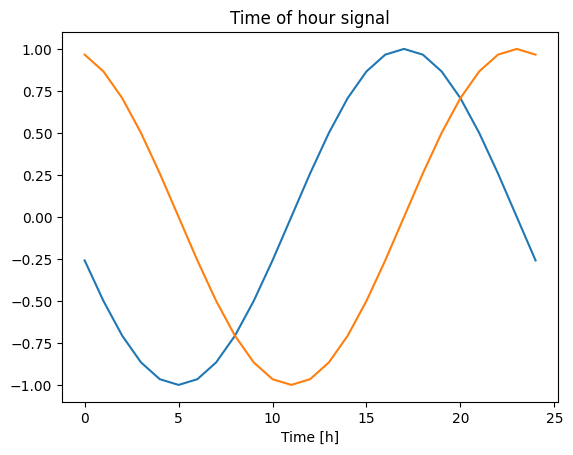

In [9]:
plt.plot(np.array(df['hour_sin'])[:25])
plt.plot(np.array(df['hour_cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of hour signal')

Here is the evolution of a few features over time:

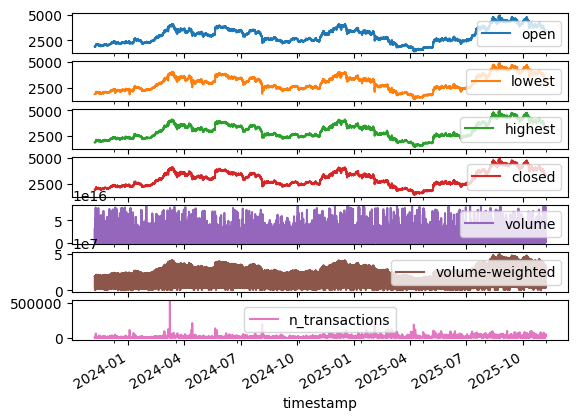

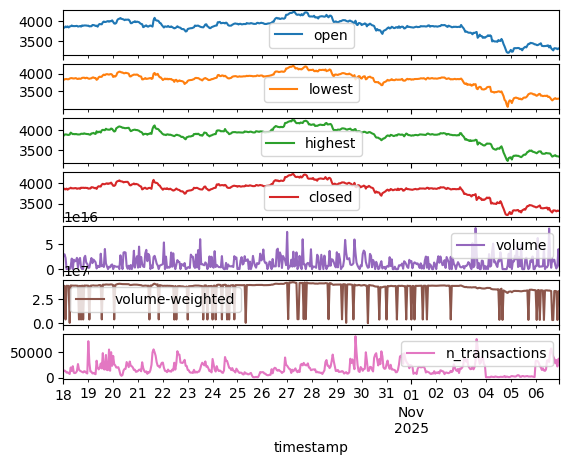

In [12]:
# convert but do NOT remove the column
date_time = pd.to_datetime(df['timestamp'], format=f'{DATE_FORMAT} {TIME_FORMAT}')

plot_cols = ['open', 'lowest', 'highest', 'closed', 'volume',
             'volume-weighted', 'n_transactions']

# full plot
plot_features = df[plot_cols].copy()
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

# first 480 rows
plot_features_480 = df[plot_cols].iloc[:480].copy()
plot_features_480.index = date_time.iloc[:480]
_ = plot_features_480.plot(subplots=True)


Looking at the received plot, we see how dynamic ETH prices (open, lowest, highest, closed) and market (volume, volume-weighted, n_transactions) are.

The first hyperparameter for computing SMA is called 'window'. The window determines in what time frame data is smoothed. To determine the window size we will use autocorrelation plot. This plot will help to understnad after how many hours is the connection between prices observed.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

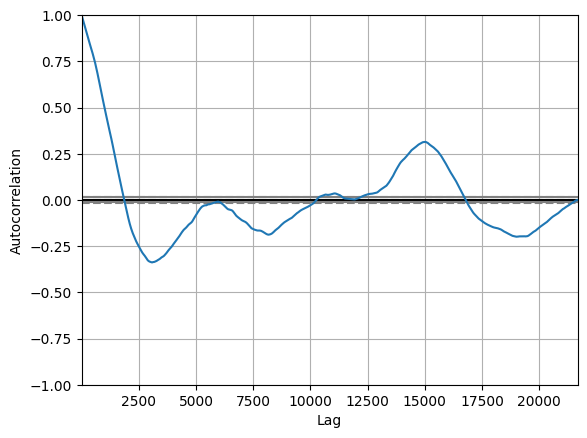

In [13]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['closed'])

95% confidence score is used. As we can see confidence interval is close to 0. Actual value is ~0.013. Since almost all of the points are not in +-0.013 range, it means data close prices are strongly related to their recent past. It confirms that data is not just a white noise, but it is significant.

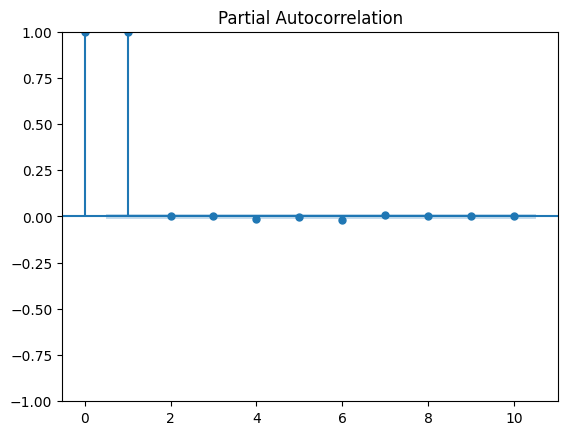

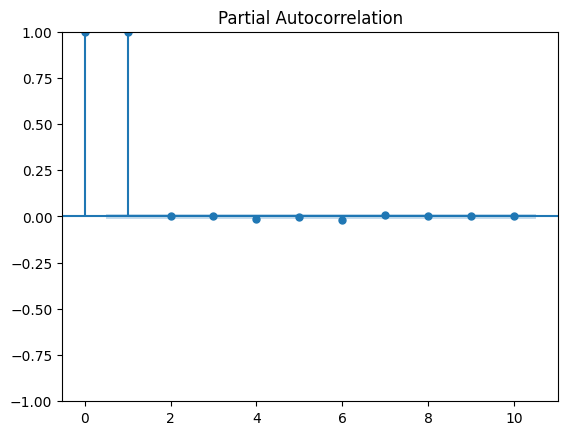

In [28]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df['closed'], lags=10)

Including just OHLCV values alone is not sufficient. This approach is basically called Candlestick pattern analysis. Usually crypto traders trade by analyzing the trend and development using trading indicators. There is a broad range of them. Trade indicators help to understand patterns in chart, price trends, signal to seel or buy. Let's consider few of them.


## Feature Expansion

### Simple moving average (SMA)

Generally speaking, it is a line charted across the candlesticks of a trading chart. This indicator sum up all closing prices of certain period of time and divide by the number of those closing prices.

Looking at Autocorrelation and Partial Correlation plots, we can make a conclusion that today’s close price is strongly related to yesterday’s close, but not directly to prices 2, 3, 4, … hours ago once you know the last one. Using very small windows won’t add much — price doesn’t depend on those tiny past intervals. That's why medium windows will taking into account - 50.

In [15]:
df['SMA_50'] = df['closed'].rolling(window=50).mean()

### Relative Strength Index (RSI)

The most basic use of an RSI is as an overbought and oversold indicator. When the RSI moves above 70, the asset is considered overbought and could decline. When the RSI is below 30, the asset is oversold and could rally. For a period, 14-period window will be used.

In [16]:
def compute_rsi(series: pd.Series, period: int = 14):
    delta = series.diff()

    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)

    # step 2: rolling averages of gains/losses
    avg_gain = pd.Series(gain).rolling(window=period, min_periods=period).mean()
    avg_loss = pd.Series(loss).rolling(window=period, min_periods=period).mean()

    # step 3: compute RS and RSI
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

In [17]:
df['RSI_14'] = compute_rsi(df['closed'])

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


### On-Balance Volume

Volume-based indicator that is used to measure the positive and negative flow of volume in a security over time. It helps confirm price movements by showing the strength of buying or selling pressure.

In [18]:
def calculate_obv(df: pd.DataFrame):
    obv = [0]
    for i in range(1, len(df)):
        if df.loc[i, 'closed'] > df.loc[i - 1, 'closed']:
            obv.append(obv[-1] + df.loc[i, 'volume'])
        elif df.loc[i, 'closed'] < df.loc[i - 1, 'closed']:
            obv.append(obv[-1] - df.loc[i, 'volume'])
        else:
            obv.append(obv[-1])
    df['OBV'] = obv

In [19]:
calculate_obv(df)

### Average True Range

It helps the model understand how noisy the market is, whether price breakouts are likely, risk levels and instability.

In [20]:
def calculate_atr(df: pd.DataFrame):
    high_low = df['highest'] - df['lowest']
    high_close_prev = (df['highest'] - df['closed'].shift()).abs()
    low_close_prev = (df['lowest'] - df['closed'].shift()).abs()
    true_range = pd.concat([high_low, high_close_prev, low_close_prev], axis=1).max(axis=1)
    df['ATR'] = true_range.rolling(window=14).mean()

In [21]:
calculate_atr(df)

In [22]:
df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,timestamp,open,lowest,highest,closed,volume,volume-weighted,n_transactions,target_next_close,hour,dayofweek,hour_sin,hour_cos,dow_sin,dow_cos,SMA_50,RSI_14,OBV,ATR
0,2025-11-06 23:00:00,3317.60,3288.16,3321.5,3313.46,5439149496040020,33019511,37020,NaN,23,3,-0.258819,0.965926,0.433884,-0.900969,NaN,NaN,0,NaN
1,2025-11-06 22:00:00,3325.74,3294.00,3330.5,3317.60,39778437737200200,33125936,36172,3313.46,22,3,-0.500000,0.866025,0.433884,-0.900969,NaN,NaN,39778437737200200,NaN
2,2025-11-06 21:00:00,3304.80,3290.80,3335.4,3324.55,7324918766570000,3308699,21589,3317.60,21,3,-0.707107,0.707107,0.433884,-0.900969,NaN,NaN,47103356503770200,NaN
3,2025-11-06 20:00:00,3324.23,3285.43,3337.0,3304.52,1324003594831000,33064478,34117,3324.55,20,3,-0.866025,0.500000,0.433884,-0.900969,NaN,NaN,45779352908939200,NaN
4,2025-11-06 19:00:00,3327.29,3306.08,3363.0,3324.23,7664137829250000,33294853,27578,3304.52,19,3,-0.965926,0.258819,0.433884,-0.900969,NaN,NaN,53443490738189200,NaN


### Now we will use API to get News during the defined timestamp. 

In [6]:
!wget https://raw.githubusercontent.com/soheilrahsaz/cryptoNewsDataset/main/csvOutput/news_currencies_source_joinedResult.rar

--2025-12-11 21:15:45--  https://raw.githubusercontent.com/soheilrahsaz/cryptoNewsDataset/main/csvOutput/news_currencies_source_joinedResult.rar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20379590 (19M) [application/octet-stream]
Saving to: ‘news_currencies_source_joinedResult.rar’

news_currencies_sou 100%[===================>]  19.43M  48.9MB/s    in 0.4s    

2025-12-11 21:15:48 (48.9 MB/s) - ‘news_currencies_source_joinedResult.rar’ saved [20379590/20379590]



In [7]:
!apt-get install -y unrar
!unrar x news_currencies_source_joinedResult.rar
!ls

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 132 not upgraded.

UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from news_currencies_source_joinedResult.rar

Extracting  news_currencies_source_joinedResult.csv                     2 4 6 8100  OK 
All OK
news_currencies_source_joinedResult.csv
news_currencies_source_joinedResult.rar


In [8]:
news_eth_df = pd.read_csv("news_currencies_source_joinedResult.csv")

news_eth_df.head()
news_eth_df.columns


/tmp/ipykernel_38/3196870231.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  news_eth_df = pd.read_csv("news_currencies_source_joinedResult.csv")


Index(['id', 'title', 'description', 'sourceId', 'sourceDomain', 'sourceUrl',
       'newsDatetime', 'url', 'negative', 'positive', 'important', 'liked',
       'disliked', 'lol', 'toxic', 'saved', 'comments', 'currencies'],
      dtype='object')

In [9]:
date_col = "newsDatetime"
text_col = "title"         
coin_col = "currencies"

news_eth_df[date_col] = pd.to_datetime(news_eth_df[date_col], errors="coerce")

start_date = "2023-11-07"
end_date = pd.Timestamp.today()

news_eth_df = news_eth_df[(news_eth_df[date_col] >= start_date) & (news_eth_df[date_col] <= end_date)]
news_eth_df.head()


,id,title,description,sourceId,sourceDomain,sourceUrl,newsDatetime,url,negative,positive,important,liked,disliked,lol,toxic,saved,comments,currencies
76516,85925,SEC Advances Spot Bitcoin ETF Talks! Is ETF Ap...,NaN,121,en.bitcoinsistemi.com,NaN,2023-12-07 15:13:06,https://cryptopanic.com/news/19093051/SEC-Adva...,0,0,0,0,0,0,0,0,0,BTC
76517,85926,"Examining Cumberland, Tether’s biggest client ...",NaN,22,protos.com,NaN,2023-12-07 15:12:30,https://cryptopanic.com/news/19093045/Examinin...,0,0,0,0,0,0,0,0,0,USDT
76518,85927,Transformative Impact: Edge AI Reshaping Indus...,NaN,122,cryptopolitan.com,NaN,2023-12-07 15:12:06,https://cryptopanic.com/news/19093039/Transfor...,0,0,0,0,0,0,0,0,0,NaN
76519,85928,Top altcoins to watch right now,NaN,8,finbold.com,NaN,2023-12-07 15:09:13,https://cryptopanic.com/news/19092992/Top-altc...,0,0,0,0,0,0,0,0,0,"ETH,XRP"
76520,85929,Dogecoin's Big Secret Exposed by DOGE Cofounde...,NaN,2,u.today,NaN,2023-12-07 15:05:00,https://cryptopanic.com/news/19092996/Dogecoin...,0,0,0,0,0,0,0,0,0,DOGE


In [10]:
!pip install vaderSentiment


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.0 MB/s eta 0:00:00


In [11]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    if pd.isna(text):
        return None
    return analyzer.polarity_scores(str(text))["compound"]

news_eth_df["sentiment"] = news_eth_df[text_col].apply(get_sentiment)

In [12]:
news_eth_df.head()

,id,title,description,sourceId,sourceDomain,sourceUrl,newsDatetime,url,negative,positive,important,liked,disliked,lol,toxic,saved,comments,currencies,sentiment
76516,85925,SEC Advances Spot Bitcoin ETF Talks! Is ETF Ap...,NaN,121,en.bitcoinsistemi.com,NaN,2023-12-07 15:13:06,https://cryptopanic.com/news/19093051/SEC-Adva...,0,0,0,0,0,0,0,0,0,BTC,0.5255
76517,85926,"Examining Cumberland, Tether’s biggest client ...",NaN,22,protos.com,NaN,2023-12-07 15:12:30,https://cryptopanic.com/news/19093045/Examinin...,0,0,0,0,0,0,0,0,0,USDT,0.0000
76518,85927,Transformative Impact: Edge AI Reshaping Indus...,NaN,122,cryptopolitan.com,NaN,2023-12-07 15:12:06,https://cryptopanic.com/news/19093039/Transfor...,0,0,0,0,0,0,0,0,0,NaN,0.0000
76519,85928,Top altcoins to watch right now,NaN,8,finbold.com,NaN,2023-12-07 15:09:13,https://cryptopanic.com/news/19092992/Top-altc...,0,0,0,0,0,0,0,0,0,"ETH,XRP",0.2023
76520,85929,Dogecoin's Big Secret Exposed by DOGE Cofounde...,NaN,2,u.today,NaN,2023-12-07 15:05:00,https://cryptopanic.com/news/19092996/Dogecoin...,0,0,0,0,0,0,0,0,0,DOGE,-0.0772


In [13]:
result = news_eth_df[[date_col, text_col, "sentiment"]].sort_values(date_col)

result.head(20)

,newsDatetime,title,sentiment
243517,2023-11-07 00:00:14,Why Quant Network QNT Will Outperform Polkadot...,0.0000
86299,2023-11-07 00:00:15,Ethereum Layer-2 Booming: Will Gas Fees Drop E...,-0.2732
84531,2023-11-07 00:00:45,Season Of Reckoning: Bitcoin Author Exposes DC...,-0.6486
82067,2023-11-07 00:30:40,Tron remains the most sought-after network for...,0.0000
81538,2023-11-07 01:00:10,Polkadot (DOT) Market Cap Dips: Q3 Sees 16% De...,0.3400
83769,2023-11-07 01:30:00,"24 Crypto Update, 06 Nov: Crypto Rally Continu...",0.0000
88850,2023-11-07 01:33:00,Aave Temporarily Pauses DeFi Markets Amid Repo...,0.0000
82533,2023-11-07 01:37:34,Ava Labs lays off 12% of staff to ‘reallocate ...,0.0000
103342,2023-11-07 02:00:11,Altcoins Rally: What’s Next After The Breakout,0.0000
151483,2023-11-07 03:59:00,"South Korea’s SK Telecom partners with Aptos, ...",0.0000


In [14]:
result["newsDatetime"] = pd.to_datetime(result["newsDatetime"])
result["timestamp"] = result["newsDatetime"].dt.floor("H")

hourly_sentiment = (
    result.groupby("timestamp")["sentiment"].mean().reset_index()
)


/tmp/ipykernel_38/3113071956.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  result["timestamp"] = result["newsDatetime"].dt.floor("H")


In [15]:
hourly_sentiment.head()

,timestamp,sentiment
0,2023-11-07 00:00:00,-0.23045
1,2023-11-07 01:00:00,0.08500
2,2023-11-07 02:00:00,0.00000
3,2023-11-07 03:00:00,0.00000
4,2023-11-07 04:00:00,-0.08670


In [33]:
combined = df.merge(
    hourly_sentiment,
    on="timestamp",
    how="left"    # keep all OHLCV rows even if sentiment missing
)
combined["sentiment"] = combined["sentiment"].fillna(0)

In [35]:
df['ret_1h'] = np.log(df['closed']).diff()

In [ ]:
leads = list(range(1, 73))

In [56]:
import math
corrs = []
tvals = []
n = df['ret_1h'].dropna().shape[0]
for lag in leads:
    r = df['sentiment'].corr(df['ret_1h'].shift(-lag))
    t = r * math.sqrt((n-2) / (1 - r**2))
    corrs.append(r)
    tvals.append(t)
    
    #print(f"Lead {lag}h: corr={r:.5f}, t={t:.2f}")


In [57]:
len(corrs)

72

In [58]:
len(tvals)

72

In [42]:
def normal_cdf(z): 
    return 0.5 * (1 + math.erf(z / math.sqrt(2)))

In [54]:
pvals = [2 * (1 - normal_cdf(abs(t))) for t in tvals]
alpha = 0.05
m = len(pvals)
sorted_idx = sorted(range(m), key=lambda i: pvals[i])
thresholds = [(i+1) * alpha / m for i in range(m)]
sig_indices = [i for i in sorted_idx if pvals[i] <= thresholds[sorted_idx.index(i)]]
sig_leads = [leads[i] for i in sig_indices]

nominal_sig = [abs(t) > 1.96 for t in tvals]


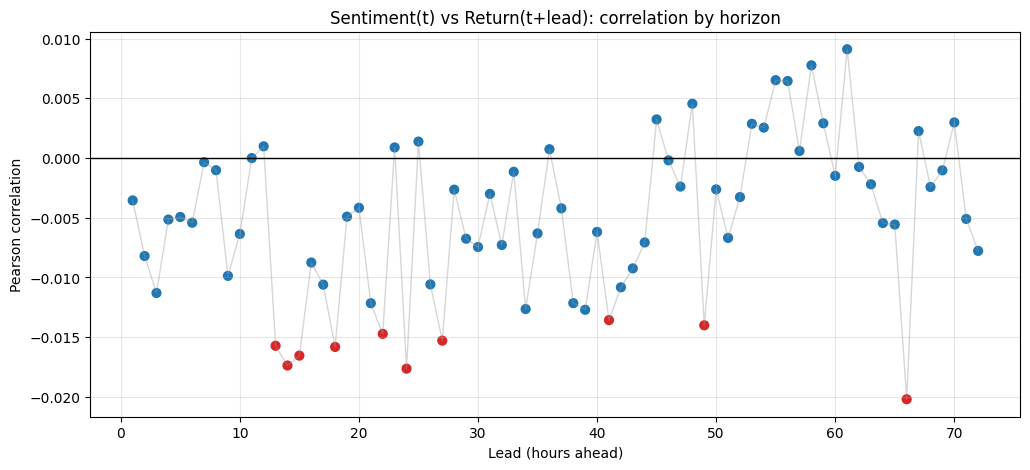

In [55]:
colors = ['#d62728' if nominal_sig[i] else '#1f77b4' for i in range(len(leads))]
plt.figure(figsize=(12,5))
plt.scatter(leads, corrs, c=colors, s=40)
plt.plot(leads, corrs, color='#999', alpha=0.4, linewidth=1)
plt.axhline(0, color='k', linewidth=1)
for L in sig_leads:
    plt.axvline(L, color='gold', linestyle='--', alpha=0.5)
plt.title('Sentiment(t) vs Return(t+lead): correlation by horizon')
plt.xlabel('Lead (hours ahead)')
plt.ylabel('Pearson correlation')
plt.grid(True, alpha=0.3)
plt.show()


In [34]:
combined["sentiment_lead_2h"] = combined["sentiment"].shift(-2)

In [35]:
combined.tail(100)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,timestamp,open,lowest,highest,closed,volume,volume-weighted,n_transactions,target_next_close,hour,...,hour_sin,hour_cos,dow_sin,dow_cos,SMA_50,RSI_14,OBV,ATR,sentiment,sentiment_lead_2h
21583,2023-11-12 03:00:00,2041.85,2038.50,2052.87,2052.34,2814008078290000,20470889,5395,2050.11,3,...,0.707107,0.707107,-0.781831,0.623490,2057.7920,51.148730,-717964362115509839,11.168571,0.000000,0.1806
21584,2023-11-12 02:00:00,2040.04,2037.50,2045.64,2042.31,22821383876499900,20420864,5450,2052.34,2,...,0.500000,0.866025,-0.781831,0.623490,2057.5230,40.945497,-740785745992009739,11.487857,0.000000,0.0000
21585,2023-11-12 01:00:00,2034.66,2026.30,2042.53,2039.86,5838084051659990,20348406,7252,2042.31,1,...,0.258819,0.965926,-0.781831,0.623490,2057.1952,31.171019,-746623830043669729,11.266429,0.180600,0.0000
21586,2023-11-12 00:00:00,2053.94,2013.50,2055.77,2034.95,10520083531910000,20311117,10519,2039.86,0,...,0.000000,1.000000,-0.781831,0.623490,2056.8314,29.748744,-757143913575579729,13.539286,0.000000,0.3286
21587,2023-11-11 23:00:00,2044.50,2035.53,2054.44,2053.83,260053207212,20439554,5872,2034.95,23,...,-0.258819,0.965926,-0.974928,-0.222521,2057.0520,53.215358,-757143653522372517,13.710000,0.000000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21678,2023-11-08 04:00:00,1883.08,1880.81,1887.01,1886.19,15748507814800000,18836999,4159,1879.96,4,...,0.866025,0.500000,0.974928,-0.222521,1953.7170,38.813638,-1124725998468616397,9.850714,-0.170200,0.0000
21679,2023-11-08 03:00:00,1888.41,1880.69,1890.10,1883.26,21107163907000000,18850078,4991,1886.19,3,...,0.707107,0.707107,0.974928,-0.222521,1948.9200,42.154210,-1145833162375616397,9.727143,0.315267,0.1324
21680,2023-11-08 02:00:00,1889.37,1886.84,1893.50,1888.40,2217718711689990,18906516,5280,1883.26,2,...,0.500000,0.866025,0.974928,-0.222521,1944.0414,40.223659,-1143615443663926407,9.399286,0.000000,-0.0850
21681,2023-11-08 01:00:00,1887.99,1886.00,1894.40,1889.37,26543527400800000,18895862,5447,1888.40,1,...,0.258819,0.965926,0.974928,-0.222521,1939.4006,50.093965,-1117071916263126407,8.602143,0.132400,NaN


## Inspect and cleanup

In [36]:
combined.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
timestamp,21683,2024-09-21 06:44:11.810173952,2023-11-08 00:00:00,2024-03-17 10:30:00,2024-08-12 06:00:00,2025-03-26 02:30:00,2025-11-06 23:00:00,NaN
open,21683.0,2986.974009,1417.45,2423.785,2963.44,3508.43,4940.8,716.110325
lowest,21683.0,2971.162811,1383.26,2414.405,2946.97,3493.015,4905.8,712.234704
highest,21683.0,3003.116748,1425.9,2434.655,2984.7,3526.85,4958.7,719.663033
closed,21683.0,2987.05647,1417.44,2424.125,2963.84,3509.055,4942.7,716.083925
volume,21683.0,12102156715071140.0,4679138.0,2580073288980495.0,7688142628760000.0,17766532800999900.0,81766127364799904.0,13279261624642860.0
volume-weighted,21683.0,27176317.951298,2660.0,22830530.5,27407528.0,34526886.0,49445105.0,10589398.236625
n_transactions,21683.0,14144.607988,24.0,7190.0,11096.0,17236.0,509158.0,12349.550404
target_next_close,21658.0,2987.172987,1417.44,2424.075,2963.94,3509.3025,4942.7,716.122992
hour,21683.0,11.49721,0.0,5.0,11.0,17.0,23.0,6.922065


## Data preprocessing for Model training

Import data preprocessing libraries

In [2]:
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

Double check that all features are in place

In [52]:
combined.tail()

,open,lowest,highest,closed,volume,volume-weighted,n_transactions,target_next_close,hour,dayofweek,hour_sin,hour_cos,dow_sin,dow_cos,SMA_50,RSI_14,OBV,ATR,sentiment,sentiment_lead_2h
21603,1879.97,1873.55,1880.81,1879.40,292853815965,18778562,3986,1875.40,6,2,1.000000,6.123234e-17,0.974928,-0.222521,1962.6230,36.816720,-1140474817597276636,10.311429,0.000000,-0.170200
21604,1885.99,1877.46,1887.34,1879.96,311313860239,18814346,4858,1879.40,5,2,0.965926,2.588190e-01,0.974928,-0.222521,1958.1736,33.140524,-1140474506283416397,10.289286,0.170000,0.315267
21605,1883.08,1880.81,1887.01,1886.19,15748507814800000,18836999,4159,1879.96,4,2,0.866025,5.000000e-01,0.974928,-0.222521,1953.7170,38.813638,-1124725998468616397,9.850714,-0.170200,0.000000
21606,1888.41,1880.69,1890.10,1883.26,21107163907000000,18850078,4991,1886.19,3,2,0.707107,7.071068e-01,0.974928,-0.222521,1948.9200,42.154210,-1145833162375616397,9.727143,0.315267,0.132400
21607,1889.37,1886.84,1893.50,1888.40,2217718711689990,18906516,5280,1883.26,2,2,0.500000,8.660254e-01,0.974928,-0.222521,1944.0414,40.223659,-1143615443663926407,9.399286,0.000000,-0.085000


In [43]:
combined.to_csv(
    "final_dataset.csv",
    mode="w",          # overwrite / create
    date_format=f"{DATE_FORMAT} {TIME_FORMAT}",
    header=True,       # write header row
    index=False
)


In [16]:
df = pd.read_csv("/kaggle/input/price-with-sentiment/final_dataset (1).csv")
df.tail()

,open,lowest,highest,closed,volume,volume-weighted,n_transactions,target_next_close,hour,dayofweek,hour_sin,hour_cos,dow_sin,dow_cos,SMA_50,RSI_14,OBV,ATR,sentiment,sentiment_lead_2h
21603,1879.97,1873.55,1880.81,1879.40,292853815965,18778562,3986,1875.40,6,2,1.000000,6.123234e-17,0.974928,-0.222521,1962.6230,36.816720,-1140474817597276636,10.311429,0.000000,-0.170200
21604,1885.99,1877.46,1887.34,1879.96,311313860239,18814346,4858,1879.40,5,2,0.965926,2.588190e-01,0.974928,-0.222521,1958.1736,33.140524,-1140474506283416397,10.289286,0.170000,0.315267
21605,1883.08,1880.81,1887.01,1886.19,15748507814800000,18836999,4159,1879.96,4,2,0.866025,5.000000e-01,0.974928,-0.222521,1953.7170,38.813638,-1124725998468616397,9.850714,-0.170200,0.000000
21606,1888.41,1880.69,1890.10,1883.26,21107163907000000,18850078,4991,1886.19,3,2,0.707107,7.071068e-01,0.974928,-0.222521,1948.9200,42.154210,-1145833162375616397,9.727143,0.315267,0.132400
21607,1889.37,1886.84,1893.50,1888.40,2217718711689990,18906516,5280,1883.26,2,2,0.500000,8.660254e-01,0.974928,-0.222521,1944.0414,40.223659,-1143615443663926407,9.399286,0.000000,-0.085000


In [17]:
cols_to_see = ['closed', 'target_next_close']
df[cols_to_see].tail()

,closed,target_next_close
21603,1879.40,1875.40
21604,1879.96,1879.40
21605,1886.19,1879.96
21606,1883.26,1886.19
21607,1888.40,1883.26


In [18]:
cols_to_see = ['sentiment', 'sentiment_lead_2h']
df[cols_to_see].tail()

,sentiment,sentiment_lead_2h
21603,0.000000,-0.170200
21604,0.170000,0.315267
21605,-0.170200,0.000000
21606,0.315267,0.132400
21607,0.000000,-0.085000


In [5]:
df.shape

(21608, 20)

In [4]:
target_cols = ["target_next_close", "sentiment_lead_2h"]

feature_cols = [c for c in df.columns if c not in target_cols]
feature_cols

['open',
 'lowest',
 'highest',
 'closed',
 'volume',
 'volume-weighted',
 'n_transactions',
 'hour',
 'dayofweek',
 'hour_sin',
 'hour_cos',
 'dow_sin',
 'dow_cos',
 'SMA_50',
 'RSI_14',
 'OBV',
 'ATR',
 'sentiment']

In [6]:
df = df.apply(pd.to_numeric, errors='ignore')

/tmp/ipykernel_38/1277559549.py:1: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


In [9]:
df["sentiment_lag_2h"] = df["sentiment"].shift(2)

In [10]:
df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,open,lowest,highest,closed,volume,volume-weighted,n_transactions,target_next_close,hour,dayofweek,...,hour_cos,dow_sin,dow_cos,SMA_50,RSI_14,OBV,ATR,sentiment,sentiment_lead_2h,sentiment_lag_2h
0,3216.6,3203.1,3290.4,3247.4,30667542333999900,32542189,841,3289.0,22,1,...,8.660254e-01,0.781831,0.62349,3358.4560,36.298172,-78018642524310879,63.992143,0.0,0.0,NaN
1,3215.9,3061.1,3217.8,3213.6,7611395329799990,31304295,1514,3247.4,21,1,...,7.071068e-01,0.781831,0.62349,3356.4588,34.559966,-85630037854110869,72.369286,0.0,0.0,NaN
2,3234.2,3125.0,3251.1,3215.5,151665005614,31692057,1932,3213.6,20,1,...,5.000000e-01,0.781831,0.62349,3354.4168,40.433547,-85629886189105255,77.430000,0.0,0.0,0.0
3,3304.8,3227.1,3315.8,3232.1,19658960891,32668762,864,3215.5,19,1,...,2.588190e-01,0.781831,0.62349,3352.5678,36.712598,-85629866530144364,81.134286,0.0,0.0,0.0
4,3373.2,3257.4,3374.4,3304.8,123872731573,33177016,2972,3232.1,18,1,...,-1.836970e-16,0.781831,0.62349,3352.5734,50.612782,-85629742657412791,87.269286,0.0,0.0,0.0


### Split

In time series dataset it is important to keep data **not** randomly shuffled. Use a (70%, 20%, 10%) split for the training, validation, and test sets.

In [11]:
n = len(df)
train_df = df[:int(0.7*n)]
val_df   = df[int(0.7*n):int(0.9*n)]
test_df  = df[int(0.9*n):]

### Normalize

Normalization is a common way of doing this scaling: subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
val_df[feature_cols]   = scaler.transform(val_df[feature_cols])
test_df[feature_cols]  = scaler.transform(test_df[feature_cols])

/tmp/ipykernel_38/578529562.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
/tmp/ipykernel_38/578529562.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df[feature_cols]   = scaler.transform(val_df[feature_cols])
/tmp/ipykernel_38/578529562.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [13]:
train_df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,open,lowest,highest,closed,volume,volume-weighted,n_transactions,target_next_close,hour,dayofweek,...,hour_cos,dow_sin,dow_cos,SMA_50,RSI_14,OBV,ATR,sentiment,sentiment_lead_2h,sentiment_lag_2h
0,0.171139,0.175876,0.246908,0.213072,1.430857,0.406478,-1.191557,3289.0,1.516768,-0.998926,...,1.224109,1.104077,0.880604,0.365998,-0.731107,-1.192182,1.327228,-0.29244,0.0,NaN
1,0.170189,-0.017640,0.148729,0.167193,-0.338003,0.293402,-1.136503,3247.4,1.372342,-0.998926,...,0.999363,1.104077,0.880604,0.363276,-0.828045,-1.211743,1.767501,-0.29244,0.0,NaN
2,0.195029,0.069442,0.193761,0.169772,-0.921936,0.328822,-1.102309,3213.6,1.227916,-0.998926,...,0.706468,1.104077,0.880604,0.360492,-0.500481,-1.211743,2.033475,-0.29244,0.0,0.0
3,0.290859,0.208584,0.281257,0.192304,-0.921946,0.418040,-1.189676,3215.5,1.083489,-0.998926,...,0.365385,1.104077,0.880604,0.357972,-0.707995,-1.211743,2.228159,-0.29244,0.0,0.0
4,0.383703,0.249876,0.360504,0.290984,-0.921938,0.464466,-1.017232,3232.1,0.939063,-0.998926,...,-0.000642,1.104077,0.880604,0.357980,0.067206,-1.211742,2.550593,-0.29244,0.0,0.0


In [14]:
test_df.head()

,open,lowest,highest,closed,volume,volume-weighted,n_transactions,target_next_close,hour,dayofweek,...,hour_cos,dow_sin,dow_cos,SMA_50,RSI_14,OBV,ATR,sentiment,sentiment_lead_2h,sentiment_lag_2h
19447,-1.107146,-1.133061,-1.114160,-1.143447,-0.921847,-2.359625,0.005241,2257.38,0.361357,-0.998926,...,-1.225392,1.104077,0.880604,-1.018435,-1.577704,-1.950237,-0.527302,-0.29244,0.318200,0.141675
19448,-1.119295,-1.107127,-1.113132,-1.105550,-0.053978,-0.488999,-0.106503,2248.02,0.216931,-0.998926,...,-1.366673,1.104077,0.880604,-1.021428,0.890312,-1.921161,-0.655126,1.74928,0.273633,0.000000
19449,-1.119295,-1.107127,-1.113132,-1.105550,-0.053978,-0.488999,-0.106503,2248.02,0.216931,-0.998926,...,-1.366673,1.104077,0.880604,-1.024422,0.890312,-1.921161,-0.669880,1.74928,0.273633,0.000000
19450,-1.072764,-1.154757,-1.084193,-1.119802,0.113009,-0.496925,0.042708,2275.94,0.072504,-0.998926,...,-1.414862,1.104077,0.880604,-1.027508,-0.173065,-1.955831,-0.477035,1.46332,0.517050,0.318200
19451,-1.072764,-1.154757,-1.084193,-1.119802,0.113009,-0.496925,0.042708,2275.94,0.072504,-0.998926,...,-1.414862,1.104077,0.880604,-1.030594,-0.173065,-1.955831,-0.255397,1.46332,0.517050,0.318200


## Model training

In [17]:
from sklearn.model_selection import GridSearchCV

### Baseline model : Xgboost

In [19]:
xg_boost_model = XGBRegressor(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8
)

In [19]:
param_grid = {
    'n_estimators': [100, 150, 200, 300, 500, 600, 700, 900], 
    'max_depth':[2,4,6,8,10,12],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1],
    'subsample': [0.1, 0.3, 0.5, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.3, 0.5, 0.8, 1]
}

grid = GridSearchCV(xg_boost_model, param_grid, cv=10, scoring='neg_mean_squared_error')
grid.fit(train_df[feature_cols], train_df['target_next_close'])
grid.best_params_

KeyboardInterrupt: 

In [20]:
xg_boost_model.fit(train_df[feature_cols], train_df['target_next_close'])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [21]:
preds = xg_boost_model.predict(test_df[feature_cols])

mae = mean_absolute_error(test_df['target_next_close'], preds)
rmse = np.sqrt(mean_squared_error(test_df['target_next_close'], preds))

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 15.245250819752137
RMSE: 19.301481036366443


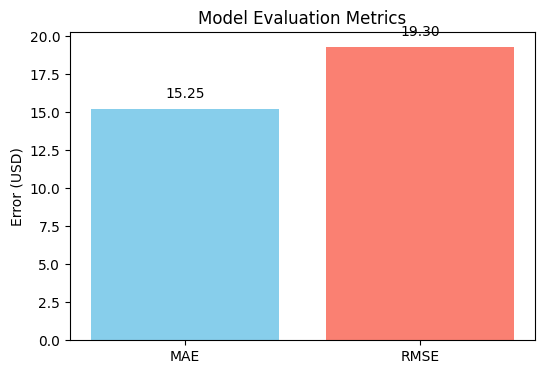

In [27]:
metrics = ['MAE', 'RMSE']
values = [mae, rmse]

plt.figure(figsize=(6, 4))
bars = plt.bar(metrics, values, color=['skyblue', 'salmon'])

# Add values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.5, f'{yval:.2f}', ha='center', va='bottom')

plt.title('Model Evaluation Metrics')
plt.ylabel('Error (USD)')
plt.show()

### LSTM / GRU Recurrent Neural Networks

In [56]:
window_size = 50  # 50 hours of history

def create_sequences(df, feature_cols, target_col, window_size):
    Xs, ys = [], []
    X_vals = df[feature_cols].values
    y_vals = df[target_col].values

    for i in range(len(df) - window_size):
        Xs.append(X_vals[i : i + window_size])
        ys.append(y_vals[i + window_size])   # predict next hour after the window

    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(train_df, feature_cols, target_col, window_size)
X_test_seq,  y_test_seq  = create_sequences(test_df,  feature_cols, target_col, window_size)

print(X_train_seq.shape, y_train_seq.shape)
print(X_test_seq.shape,  y_test_seq.shape)

(15075, 50, 18) (15075,)
(2111, 50, 18) (2111,)


In [65]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error

n_features = len(feature_cols)  # FIXED

lstm_model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(window_size, n_features)),
    Dropout(0.2),
    LSTM(64, return_sequences=True),   
    Dropout(0.2),
    Dense(1)
])

lstm_model.compile(
    loss="mse",
    optimizer="adam",
    metrics=["mae"]
)

es = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = lstm_model.fit(
    X_train_seq, y_train_seq,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    shuffle=False,
    callbacks=[es],
    verbose=1
)

lstm_preds = lstm_model.predict(X_test_seq).flatten()
lstm_mae = mean_absolute_error(y_test_seq, lstm_preds)
lstm_rmse = np.sqrt(mean_squared_error(y_test_seq, lstm_preds))

print("LSTM MAE:", lstm_mae)
print("LSTM RMSE:", lstm_rmse)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 29s 124ms/step - loss: 12454934.0000 - mae: 3409.5930 - val_loss: 11025816.0000 - val_mae: 3304.1177
Epoch 2/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 23s 119ms/step - loss: 12341097.0000 - mae: 3392.0330 - val_loss: 10939921.0000 - val_mae: 3291.0959
Epoch 3/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 23s 119ms/step - loss: 12253925.0000 - mae: 3379.1772 - val_loss: 10857649.0000 - val_mae: 3278.5732
Epoch 4/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 23s 119ms/step - loss: 12169747.0000 - mae: 3366.7058 - val_loss: 10776992.0000 - val_mae: 3266.2500
Epoch 5/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 23s 120ms/step - loss: 12087250.0000 - mae: 3354.4287 - val_loss: 10697546.0000 - val_mae: 3254.0659
Epoch 6/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 22s 118ms/step - loss: 12006054.0000 - mae: 3342.2991 - val_loss: 10619193.0000 - val_mae: 3242.0044
Epoch 7/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 23s 119ms/step - loss: 11925927.0000 - mae: 3330.2917 - val_loss: 10541827.0000 - val_mae: 3230.0483
Epoch 8/50
18

ValueError: Found input variables with inconsistent numbers of samples: [2111, 105550]

In [64]:
lstm_preds = lstm_model.predict(X_test_seq).flatten()

lstm_mae = mean_absolute_error(y_test_seq, lstm_preds)
lstm_rmse = np.sqrt(mean_squared_error(y_test_seq, lstm_preds))

print("LSTM MAE:", lstm_mae)
print("LSTM RMSE:", lstm_rmse)


66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
LSTM MAE: 1904.2321991946947
LSTM RMSE: 1908.0898764563103


In [60]:
lstm_preds = lstm_model.predict(X_test_seq).flatten()
lstm_preds

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


array([306.18414, 306.18414, 306.18414, ..., 306.18414, 306.18414,
       306.18414], dtype=float32)

### Feature selection.

### Download the model.

In [33]:
joblib.dump(scaler, "scaler.pkl")  # save scaler

['scaler.pkl']

In [32]:
import joblib

# Save the trained model
joblib.dump(xg_boost_model, "eth_xgb_model.pkl")

['eth_xgb_model.pkl']